In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

###
# Recreation of Jegadessh and Titman's (1993) momentum strategy
# Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency
# based on current stock price data.
# This script implements a momentum-based trading strategy using stock price data.
###

# Load stock price data
data_dir = Path("stock_info")
price_data = {}

for file in data_dir.glob("*.csv"):
    try:
        df = pd.read_csv(file, parse_dates=["Date"])
        df["Close/Last"] = df["Close/Last"].replace('[\$,]', '', regex=True).astype(float)
        df = df.sort_values("Date").set_index("Date")
        price_data[file.stem] = df["Close/Last"]
    except Exception as e:
        print(f"Failed to load {file.name}: {e}")

# Combine and prepare price data
prices = pd.DataFrame(price_data)
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()
monthly_prices = prices.resample("M").last()
monthly_prices = monthly_prices.dropna(axis=1, thresh=int(0.8 * len(monthly_prices)))
monthly_returns = monthly_prices.pct_change().dropna()

# Create output directory
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)

<>:22: SyntaxWarning: invalid escape sequence '\$'
<>:22: SyntaxWarning: invalid escape sequence '\$'
C:\Users\NickPC\AppData\Local\Temp\ipykernel_740\1462694776.py:22: SyntaxWarning: invalid escape sequence '\$'
  df["Close/Last"] = df["Close/Last"].replace('[\$,]', '', regex=True).astype(float)
C:\Users\NickPC\AppData\Local\Temp\ipykernel_740\1462694776.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = prices.resample("M").last()


In [12]:
params = [3, 6, 9, 12]
results = {}

for lookback_months in params:
    for holding_months in params:
        print(f"Processing J={lookback_months}, K={holding_months}")
        try:
            future_returns = monthly_prices.pct_change(periods=holding_months).shift(-holding_months)
            rebalance_dates = monthly_returns.index[lookback_months:-holding_months]

            active_portfolios = []
            portfolio_returns = defaultdict(list)

            for date in rebalance_dates:
                try:
                    start_date = monthly_prices.index[monthly_prices.index.get_loc(date) - lookback_months - 1]
                    end_date = monthly_prices.index[monthly_prices.index.get_loc(date) - 1]

                    past_price = monthly_prices.loc[start_date]
                    recent_price = monthly_prices.loc[end_date]

                    momentum_scores = (recent_price / past_price) - 1
                    momentum_scores = momentum_scores.dropna()

                    ranked = momentum_scores.rank(pct=True)
                    deciles = pd.qcut(ranked, 10, labels=False)

                    future_date = monthly_prices.index[monthly_prices.index.get_loc(date) + holding_months]
                    if future_date not in future_returns.index:
                        continue

                    for decile in range(10):
                        stocks = momentum_scores.index[deciles == decile]
                        if len(stocks) == 0:
                            continue

                        active_portfolios.append({
                            "start_date": date,
                            "end_date": future_date,
                            "decile": decile + 1,
                            "stocks": stocks
                        })

                    for port in active_portfolios[:]:
                        if date >= port["end_date"]:
                            active_portfolios.remove(port)
                            continue

                        valid_stocks = [s for s in port["stocks"] if s in future_returns.columns]
                        if not valid_stocks or date not in future_returns.index:
                            continue

                        monthly_return = future_returns.loc[date, valid_stocks].mean()
                        portfolio_returns[(date, port["decile"])].append(monthly_return)

                except Exception as e:
                    print(f"Error on {date.date()} for J={lookback_months}, K={holding_months}: {e}")

            # Average overlapping returns
            final_data = []
            for (date, decile), rets in portfolio_returns.items():
                final_data.append({
                    "Date": date,
                    "Decile": decile,
                    "Return": np.mean(rets)
                })

            portfolio_df = pd.DataFrame(final_data)
            portfolio_df = portfolio_df.sort_values("Date")

            # Calculate cumulative returns for plotting
            portfolio_df["Cumulative Return"] = (
                portfolio_df.groupby("Decile")["Return"]
                .transform(lambda x: (1 + x).cumprod())
            )

            results[(lookback_months, holding_months)] = portfolio_df

            # Save to CSV
            output_file = output_dir / f"momentum_J{lookback_months}_K{holding_months}.csv"
            portfolio_df.to_csv(output_file, index=False)
        
        except Exception as e:
            print(f"Failed processing for J={lookback_months}, K={holding_months}: {e}")

Processing J=3, K=3
Processing J=3, K=6
Processing J=3, K=9
Processing J=3, K=12
Processing J=6, K=3
Processing J=6, K=6
Processing J=6, K=9
Processing J=6, K=12
Processing J=9, K=3
Processing J=9, K=6
Processing J=9, K=9
Processing J=9, K=12
Processing J=12, K=3
Processing J=12, K=6
Processing J=12, K=9
Processing J=12, K=12


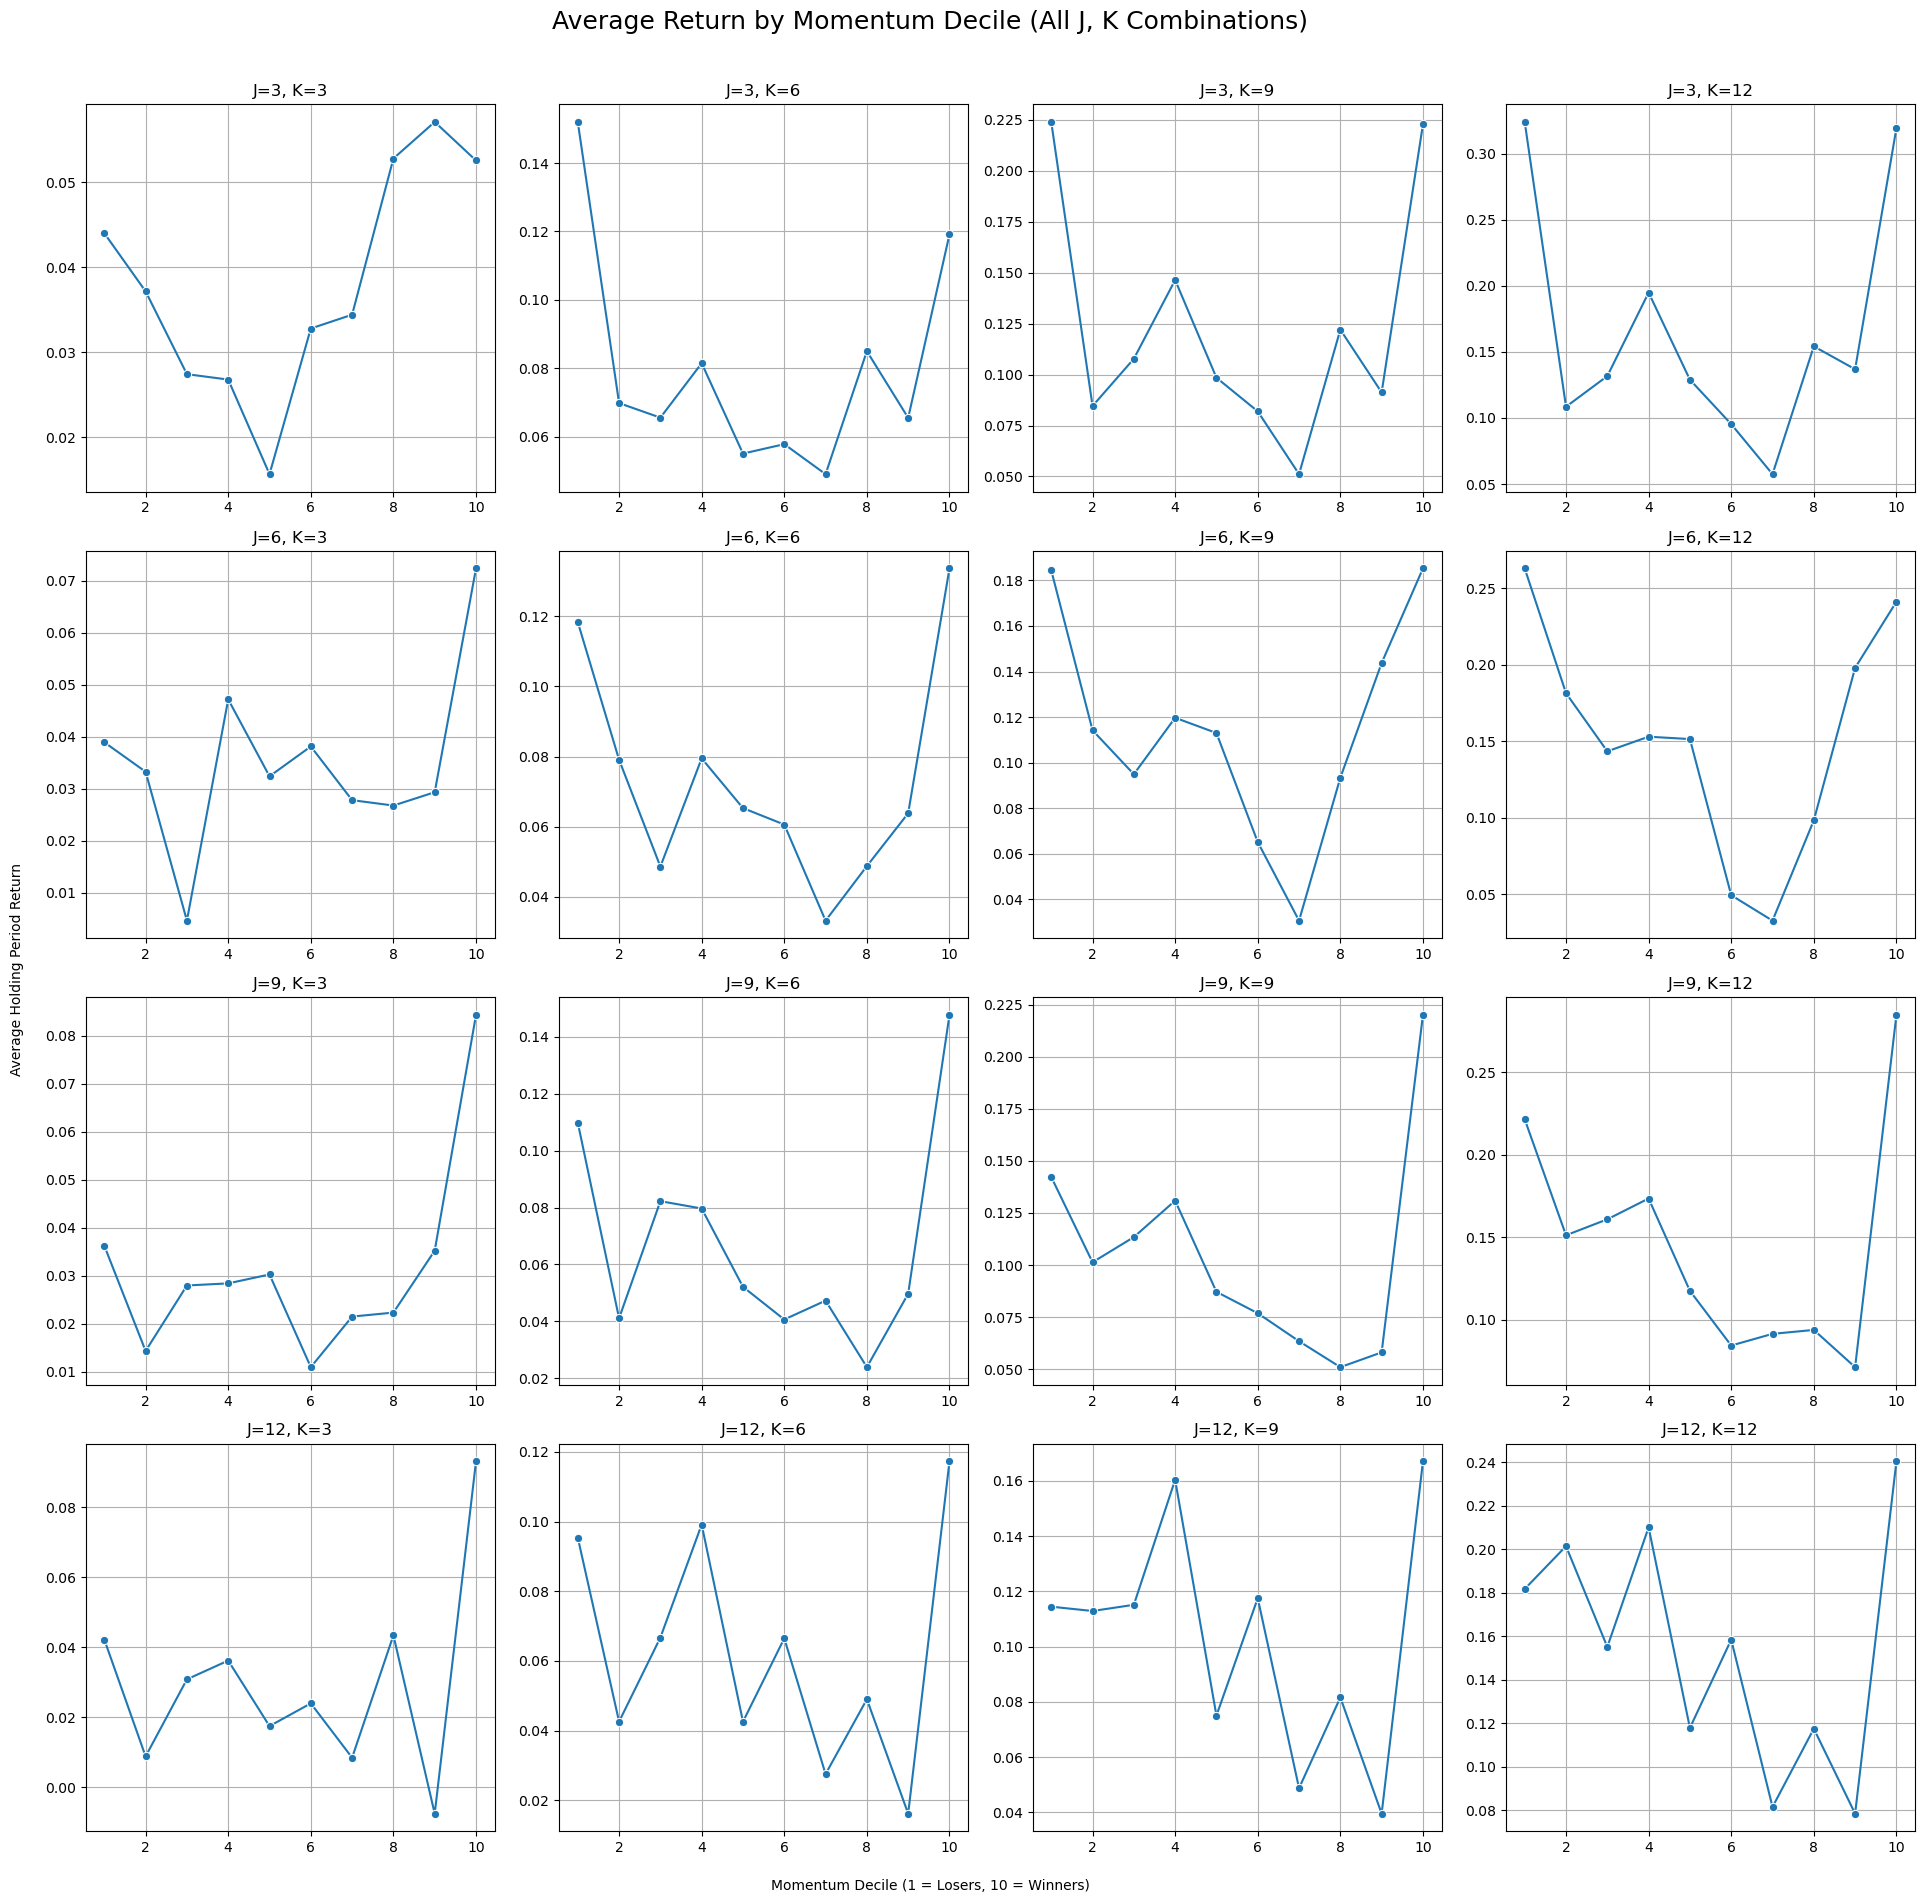

In [13]:
combos = [(j, k) for j in params for k in params]

# Average Return per Decile Plot
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Average Return by Momentum Decile (All J, K Combinations)", fontsize=18)

for i, (j, k) in enumerate(combos):
    row, col = divmod(i, 4)
    ax = axs[row, col]
    df = results.get((j, k))
    if df is not None:
        avg_returns = df.groupby("Decile")["Return"].mean().reset_index()
        sns.lineplot(data=avg_returns, x="Decile", y="Return", marker="o", ax=ax)
        ax.set_title(f"J={j}, K={k}")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True)

fig.text(0.5, 0.04, "Momentum Decile (1 = Losers, 10 = Winners)", ha='center')
fig.text(0.04, 0.5, "Average Holding Period Return", va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.savefig(output_dir / "grid_avg_return_by_decile.png")
plt.show()
plt.close()

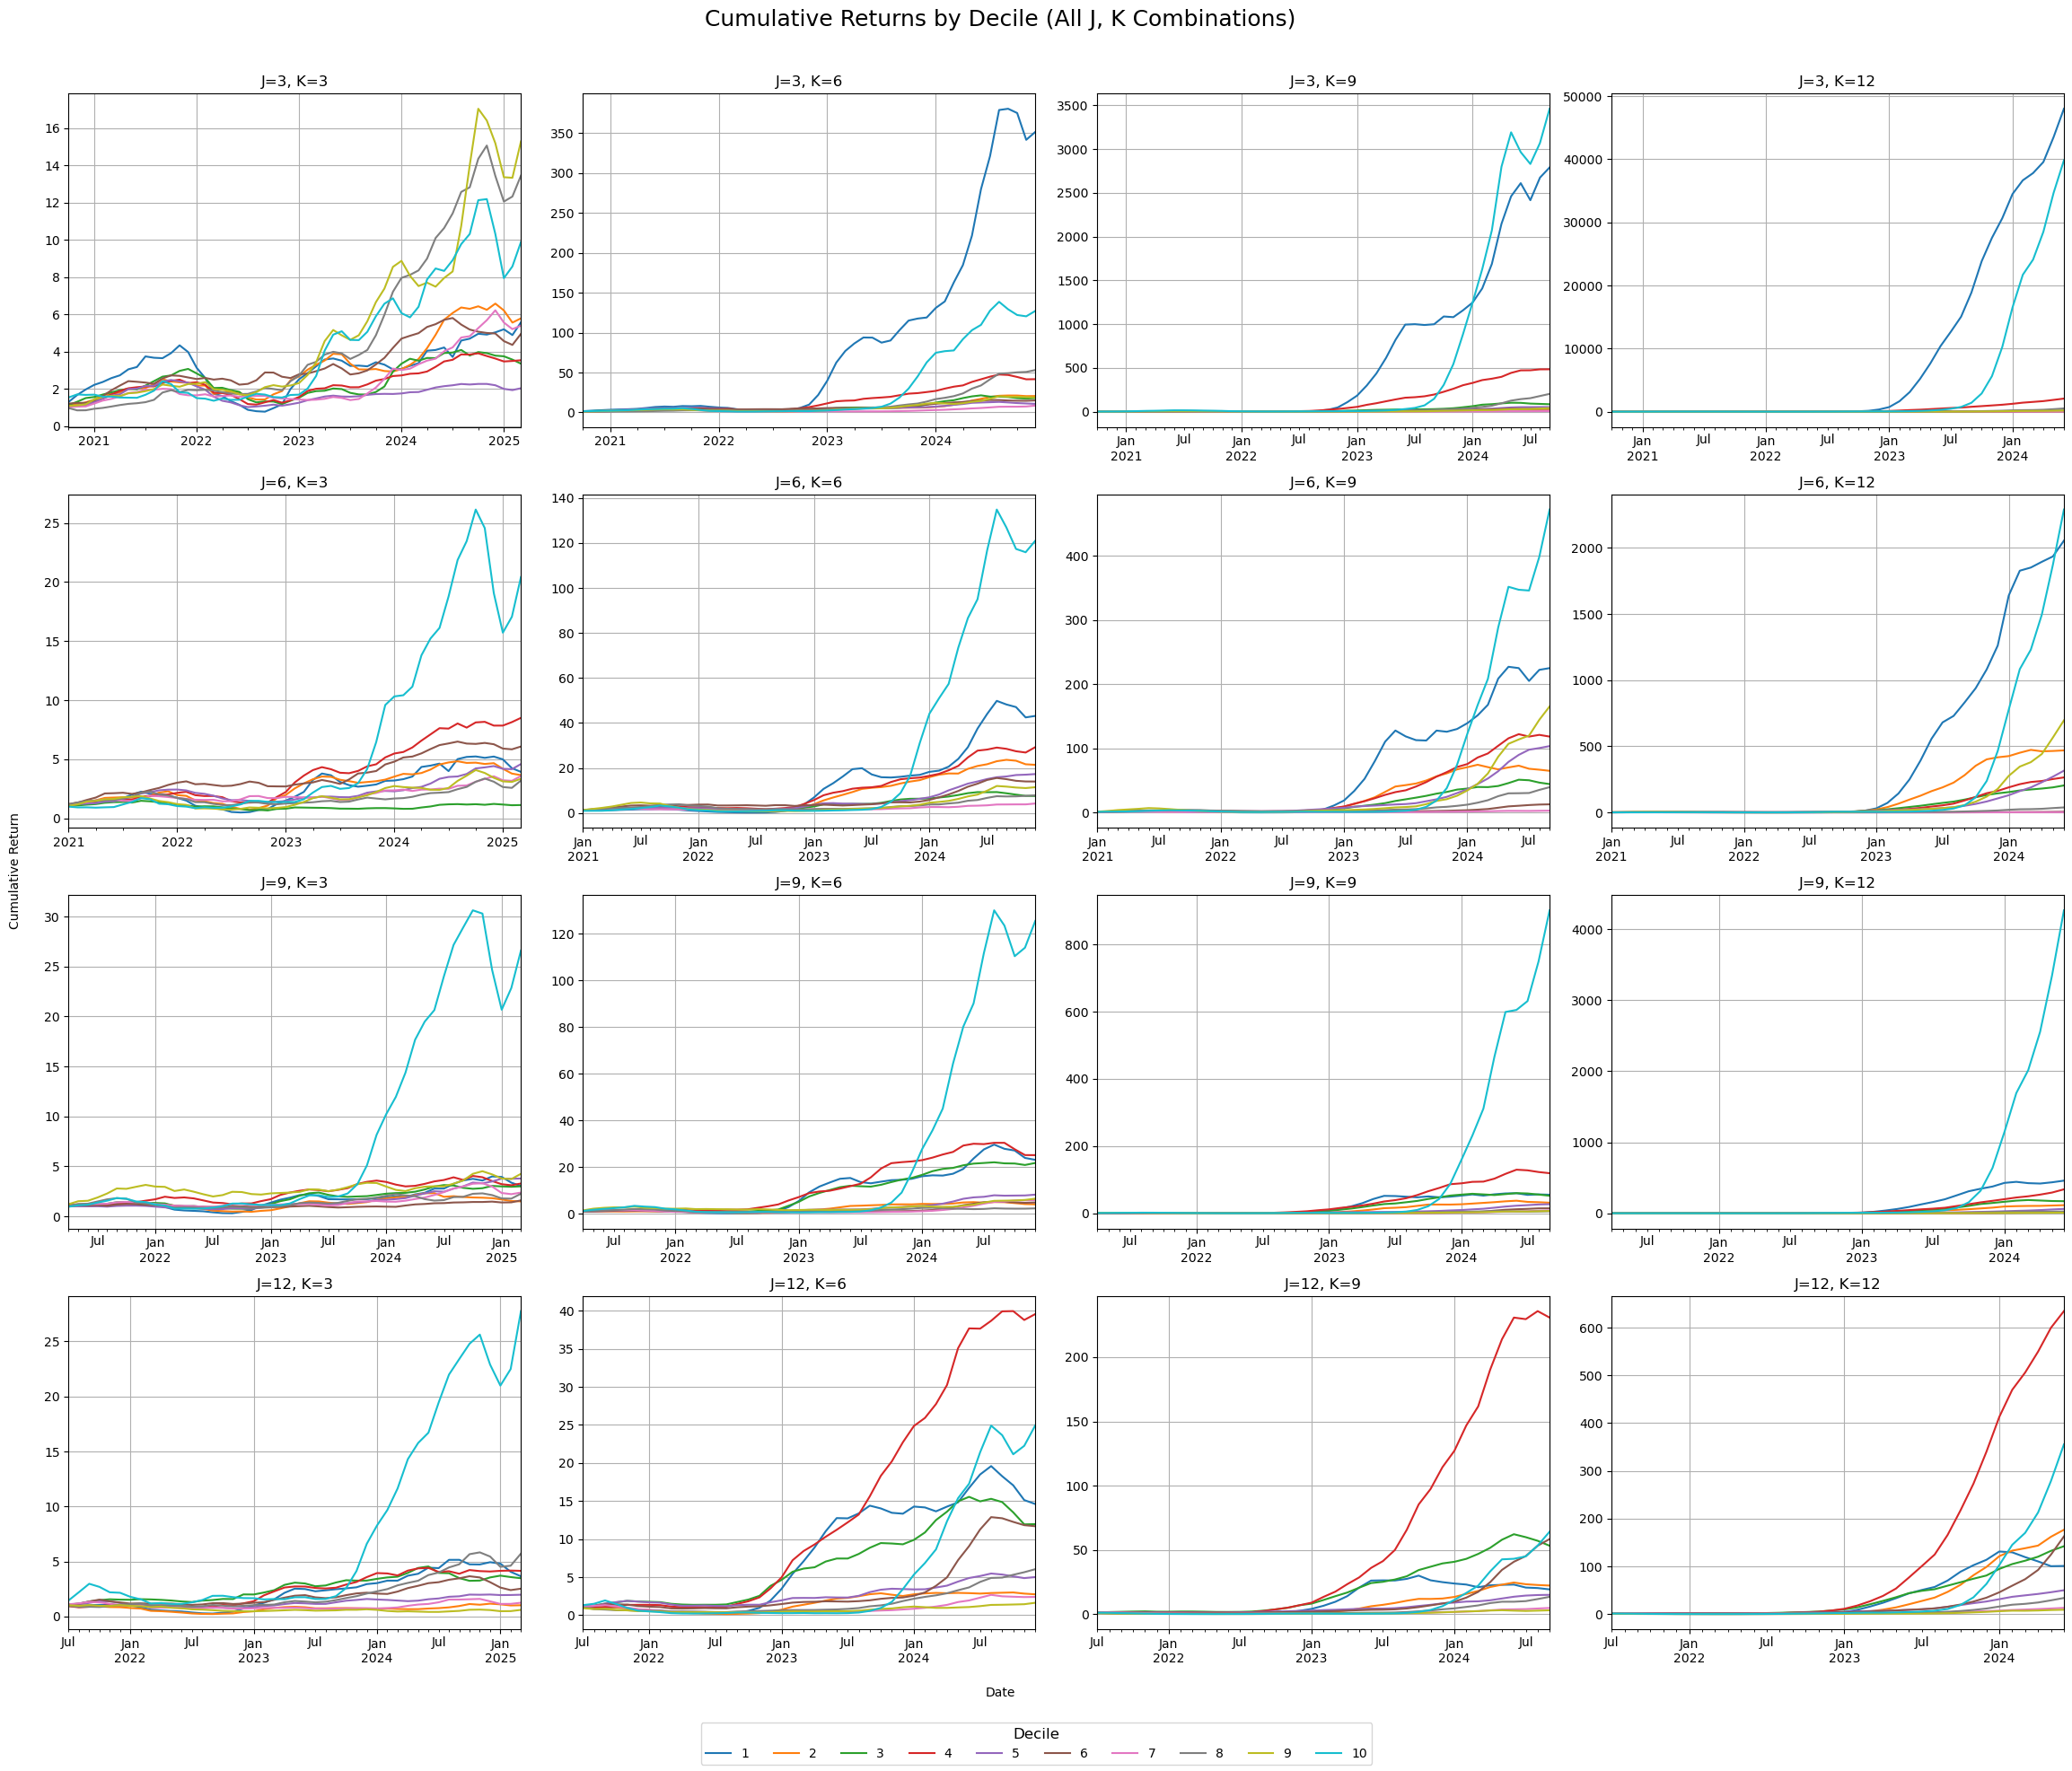

In [14]:
# Cumulative Returns Plot
fig, axs = plt.subplots(4, 4, figsize=(24, 20), sharex=False, sharey=False)
fig.suptitle("Cumulative Returns by Decile (All J, K Combinations)", fontsize=18)

for i, (j, k) in enumerate(combos):
    row, col = divmod(i, 4)
    ax = axs[row, col]
    df = results.get((j, k))
    if df is not None:
        cumulative_returns = (
            df.pivot(index="Date", columns="Decile", values="Return")
            .fillna(0)
            .add(1).cumprod()
        )
        cumulative_returns.plot(ax=ax, legend=False, colormap="tab10")
        ax.set_title(f"J={j}, K={k}")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=10, title='Decile', fontsize='medium', title_fontsize='large')

fig.text(0.5, 0.04, "Date", ha='center')
fig.text(0.04, 0.5, "Cumulative Return", va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.savefig(output_dir / "grid_cumulative_returns_by_decile.png")
plt.show()
plt.close()

In [15]:
# To implement, heatmap of J = 3,6,9,12; K = 3,6,9,12 for returns based on values
# Sharpe ratio, drawdown?